<a href="https://colab.research.google.com/github/Krishnan-Raghavan/Packt/blob/main/StableDiffusionChapter18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Apr 15 14:28:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from transformers import CLIPSegProcessor,CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)
model = CLIPSegForImageSegmentation.from_pretrained(
    "CIDAS/clipseg-rd64-refined"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

In [3]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.wh

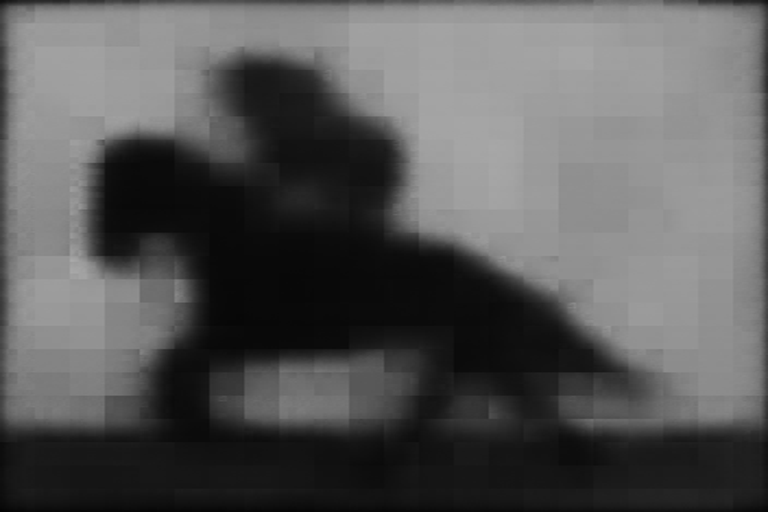

In [4]:
from diffusers.utils import load_image
from diffusers.utils.pil_utils import numpy_to_pil
import torch

source_image = load_image("/content/clipseg_source_image.png")

prompts = ['the background']
inputs = processor(
    text             = prompts
    , images         = [source_image] * len(prompts)
    , padding        = True
    , return_tensors = "pt"
)

with torch.no_grad():
    outputs = model(**inputs)

preds = outputs.logits
mask_data = torch.sigmoid(preds)

mask_data_numpy = mask_data.detach().unsqueeze(-1).numpy()
mask_pil = numpy_to_pil(mask_data_numpy)[0].resize(source_image.size)

mask_pil

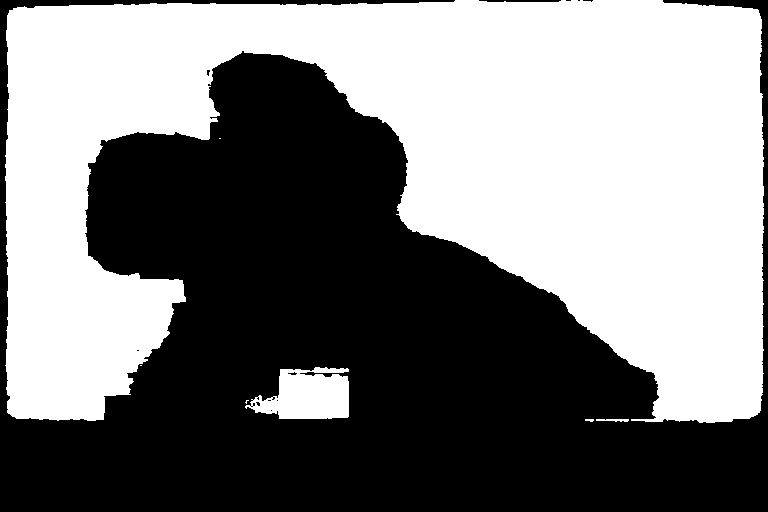

In [5]:
bw_thresh = 100
bw_fn = lambda x : 255 if x > bw_thresh else 0
bw_mask_pil = mask_pil.convert("L").point(bw_fn, mode="1")
bw_mask_pil

In [10]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4"
    , torch_dtype = torch.float16
    , safety_checker = None
).to("cuda:0")

sd_prompt = "blue sky and mountains"
out_image = inpaint_pipe(
    prompt          = sd_prompt
    , image         = source_image
    , mask_image    = bw_mask_pil
    , strength      = 0.9
    , generator     = torch.Generator("cuda:0").manual_seed(7)
).images[0]
out_image

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:749: FutureWarning: You are using a legacy checkpoint for inpainting with Stable Diffusion, therefore we are loading the <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> class instead of <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'>. For better inpainting results, we strongly suggest using Stable Diffusion's official inpainting checkpoint: https://huggingface.co/runwayml/stable-diffusion-inpainting instead or adapting your checkpoint CompVis/stable-diffusion-v1-4 to the format of https://huggingface.co/runwayml/stable-diffusion-inpainting. Note that we do not actively maintain the {StableDiffusionInpaintPipelineLegacy} class and will likely remove it in version 1.0.0.
  deprecate("StableDiffusionInpaintPipelineLegacy", "1.0.0", deprecation_message, s

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install accelerate`

In [9]:
!jupyter nbconvert --execute main.ipynb

[NbConvertApp] WARNING | pattern 'main.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execut

In [7]:
!pip install accelerate

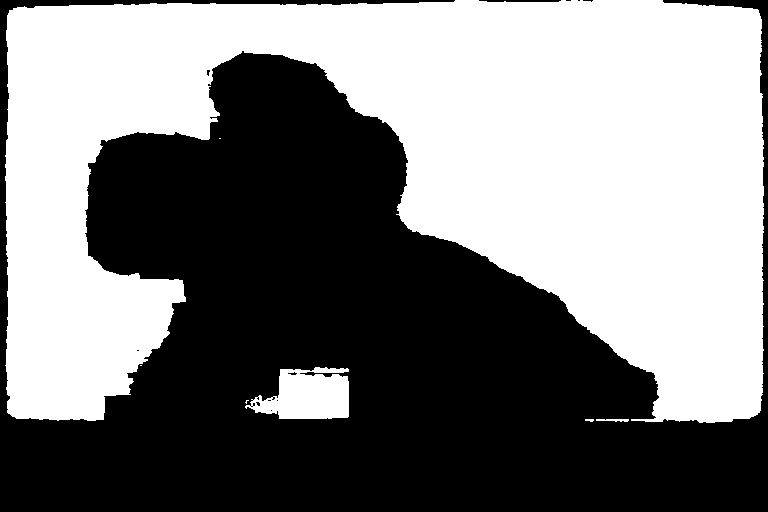

In [11]:
bw_thresh = 100
bw_fn = lambda x : 255 if x > bw_thresh else 0
bw_mask_pil = mask_pil.convert("L").point(bw_fn, mode="1")
bw_mask_pil

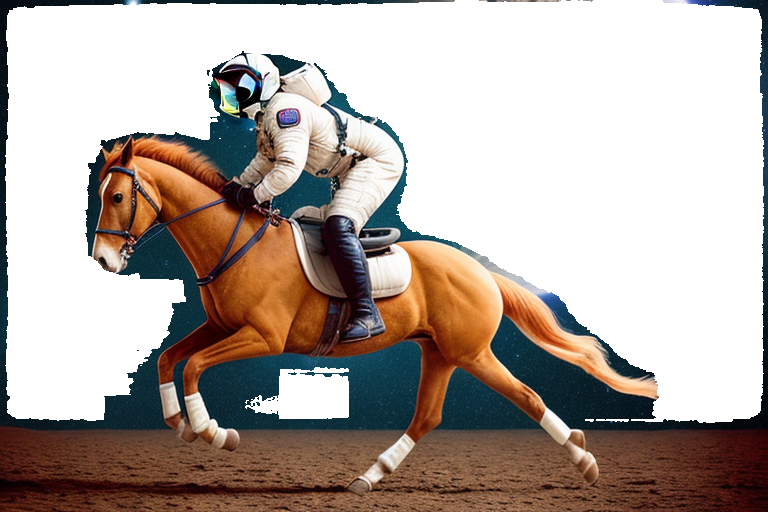

In [12]:
from PIL import Image, ImageOps
output_image = Image.new("RGBA", source_image.size, (255,255,255,255))
inverse_bw_mask_pil = ImageOps.invert(bw_mask_pil)
r = Image.composite(source_image ,output_image, inverse_bw_mask_pil)
r

In [13]:
from rembg import remove
remove(source_image)

ModuleNotFoundError: No module named 'rembg'

In [14]:
from rembg import remove
from PIL import Image
#white_bg = Image.new("RGBA", source_image.size, (255,255,255))
black_bg = Image.new("RGBA", source_image.size, (0,0,0))
image_wo_bg = remove(source_image)
img_wo_bg = Image.alpha_composite(black_bg, image_wo_bg)
img_wo_bg

ModuleNotFoundError: No module named 'rembg'

In [15]:
import torch
from transformers import CLIPVisionModelWithProjection
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder   = "models/image_encoder",
    torch_dtype = torch.float16,
).to("cuda:0")

models/image_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.53G [00:00<?, ?B/s]

In [16]:
from diffusers import StableDiffusionImg2ImgPipeline
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    image_encoder   = image_encoder,
    torch_dtype     = torch.float16,
    safety_checker  = None
).to("cuda:0")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install accelerate`

In [17]:
pipeline.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder       = "models",
    weight_name     = "ip-adapter_sd15.bin"
)

NameError: name 'pipeline' is not defined

In [19]:
from diffusers.utils import load_image

source_image = load_image("/content/clipseg_source_image.png")
ip_image = load_image("/content/vermeer.png")

pipeline.to("cuda:0")

image = pipeline(
    prompt                   = 'best quality, high quality'
    , negative_prompt        = "monochrome,lowres, bad anatomy,low quality"
    , image                  = source_image
    , ip_adapter_image       = ip_image
    , num_images_per_prompt  = 1
    , num_inference_steps    = 50
    , strength               = 0.5
    , generator              = torch.Generator("cuda:0").manual_seed(1)
).images[0]

pipeline.to("cpu")
torch.cuda.empty_cache()
image

NameError: name 'pipeline' is not defined